# Extended Deep Q-Learning for Multilayer Perceptron

### 1. Basics

### The Reinforcement Learning Framework:
- reinforcement learning (RL) framework is characterized by an agent learning to interact with its environment
- at each time step, the agent receives the environment's state 
- the agent must choose an appropriate action in response
- at the next time step, the agent receives a reward and a new state
- the agent has the goal to maximize the expected cumulative reward


### Policy:
- we can distinguish between deterministic and stochastic policy
##### Deterministic policy:
- a mapping from state to action
    - $\pi : S \to A$
    - for each state $s \in S$ it yields the action $a \in A$ that the agent will choose while in state $s$
####  Stochastic policy:
- a mapping from state to action probability 
    - $\pi : S \times A \to [0,1]$
    - for each state $s \in S$ it and action $a \in A$ it yields the probability $\pi(a|s)$ that the agent chooses action $a$ while in state $s$

### State-Value Functions:

- state-value function for a policy $\pi$ is denoted $v_\pi$
- $v_\pi = \mathbb{E_\pi}[G_t | S_t = s]$
    - for each state $s \in S$, it yields the expected return if the agent starts in state $s$ and then uses the policy $\pi$ to choose its actions $a$ for all remaining time steps
    - $\mathbb{E_\pi}$ is the expected value of a random variable, given that the agent follows policy $\pi$
    
### Action-Value Functions:

- action-value function for a policy  $\pi$ is denoted $q_\pi$
- $q_\pi(s, a) = \mathbb{E_\pi}[G_t | S_t = s, A_t = a]$
    - for each state $s \in S$ and action $a \in A$ tuple, it yields the expected return if the agent starts in state $s$, takes action $a$, and then follows the policy for all remaining time steps
    - $\mathbb{E_\pi}$ is the expected value of a random variable, given that the agent follows policy $\pi$
    
### Temporal Difference:
- $TD_t(a_t, s_t) = r_t + \gamma max_a(Q(a, s_{t+1})) - Q(a, s_t)$ <p>
$r_t$: reward $r_t$ obtained by playing the action $a_t$ in the state $s_t$<br>
$\gamma$: discount factor(hyperparameter)<br>
$max_a(Q(a, s_{t+1}))$: Q-value of the best action played in the state $s_{t+1}$<br>
$Q(a, s_t)$: Q-value of the action $a_t$ played in the state $s_t$
    
- use the temporal difference $TD_t(a_t, s_t)$ to update $Q(a, s_t)$ 
    - $Q(a, s_t) = Q(a, s_t) + \alpha * TD_t(a_t, s_t) $ 
    - the action value function is updated after every time step

### 2. Deep Q-Learning

![alt text](images/Generalization-of-Q-learning-with-neural-network.png "Q_Learning_Network")
[Image Source](https://www.researchgate.net/profile/Jason_Gu2/publication/251898588/figure/fig1/AS:358420172558336@1462465436051/Generalization-of-Q-learning-with-neural-network.png)

- in deep Q-learning, we use an artificial neural network as q value function
    - the input to the network is the environment states
    - the output of the network is a q-value for all possible actions
    - we can now select the action based on this q-values
        - for example by using an $\epsilon$-greedy policy
    - the network is updated by using the temporal difference method

### 3. Implemented Extensions

### Fixed Q-Targets:
- in vanilla Q-Learning, we are updating a guess for the q values with a guess
- this can potentially lead to harmful correlations
- we can break these correlations by using fixed Q-Targets meaning we are using two separated networks
    - new updaterule: $\Delta w = \alpha * (r_t + \gamma max_a(Q(a, s_{t+1}, w^-)) - Q(a, s_t, w)) \nabla_w Q(a, s_t, w)$
    - $w^-$ are the weights of a separate target network that are not changed during the learning step
        - target Q-Network weights are updated less often(or more slowly) than the Q-Network
        
### Experience Replay:
- deals with the problem that the sequence of experience tuples can be highly correlated
- by learning from this experience tuples in sequential order, we run into the risk of getting swayed by the effects of this correlation
- we can handle this problem by saving the last $m$ transitions
    - $m$ is a large number
    - a transition (or experience) is often defined as a tuple in the form of (state, action, reward, next_state, done)
- the pack of the last transition is called experience replay(or replay buffer)
- from this replay buffer, we take random batches of transitions to make updates to the network
    - this randomness breaks the correlation
    - this also allows us to learn more from individual tuples multiple times

### Gradient Clipping:
- deals with the problem of exploding gradients
    - gradient gets exponentially large from being multiplied by numbers larger than 1
- gradient clipping puts the gradients in a range between a min and max value to avoid this problem

### Double Deep Q-Learning:
- addresses the problem of overestimation of the Q-Values
- the Q-Values depend a lot on what actions have been already tried and what states have been explored
- that means that choosing the right max value can be error-prone especially in the early stages
    - that is because the Q-values are still evolving and we might need more information to figure out the best action
    - we are basically choosing the max value among a set of noisy numbers which leads to the overestimation
- to solve this problem, we select the best action using one set of parameters $w$ but evaluate it using a different set of parameters $w^-$
    - we can use our already introduced target Q-Network for this
- that means we have two separate function approximators that must agree on the best action
    - if $w$ picks an action that is not the best according to $w^-$ then the estimated Q-Value is not that high
    

### Dueling Networks:

![alt text](images/dueling_dqn.png "Dueling_Q_Learning_Network")
[Image Source](https://coach.nervanasys.com/algorithms/value_optimization/dueling_dqn/index.html)

- the core idea of dueling networks is to use a specialized Dueling Q Head to separate $Q$ to an $A$ (advantage) stream and a $V$ (state value) stream
    - the streams may share some layers at the beginning then branch off with their own fully connected layers
    - this allows the network to differentiate actions from one another better
- the reason for this is that the value of most states do not vary a lot across actions
    - we can start learning the state-value even if only a single action has been taken at this state
- this leads to faster learning, but we still need to capture the difference that actions make in each state
    - the advantage stream realizes this

### 4. Examples

In [1]:
%matplotlib inline

import gym
import json
import os
import helper
from dqn_agent import Agent
import sessions

# ignore gymn warnings
import warnings
warnings.filterwarnings('ignore')

### Environment: Lunar_Lander_v2

- LunarLander-v2 defines "solving" as getting average reward of 200 over 100 consecutive trials

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode 100	Average Score: -214.30
Episode 200	Average Score: -152.37
Episode 300	Average Score: -96.496
Episode 400	Average Score: -65.861
Episode 500	Average Score: 84.633
Episode 600	Average Score: 169.72
Episode 700	Average Score: 192.23
Episode 758	Average Score: 200.30
LunarLander-v2 Environment solved in 658 episodes!


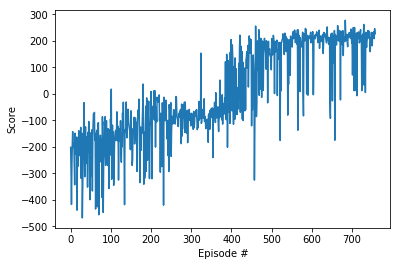

Best 100-episode performance: 200.2989085178099 +/- 59.337490722745


In [2]:
with open(os.path.join(".", "configs", "Lunar_Lander_v2.json"), "r") as read_file:
    config = json.load(read_file)
    
env = gym.make(config["general"]["env_name"])
env.seed(config["general"]["seed"])
agent = Agent(config=config)

if config["train"]["run_training"]:
    scores, best_mean, best_std = sessions.train(agent, env, config)
    helper.plot_scores(scores)
    print("Best 100-episode performance: {} +/- {}".format(best_mean, best_std))
    agent.save()
else:
    agent.load()
    score = sessions.test(agent, env, config)
    print("Episode score: {}".format(score))

### Environment: Acrobot-v1

- Acrobot-v1 is an unsolved environment
    - it does not have a specified reward threshold at which it's considered solved

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode 100	Average Score: -487.30
Episode 200	Average Score: -343.34
Episode 300	Average Score: -201.39
Episode 400	Average Score: -178.74
Episode 500	Average Score: -126.87
Episode 600	Average Score: -117.44
Episode 700	Average Score: -101.06
Episode 800	Average Score: -104.88
Episode 900	Average Score: -98.000
Episode 1000	Average Score: -92.94
Episode 1100	Average Score: -92.24
Episode 1200	Average Score: -85.74
Episode 1300	Average Score: -80.71
Episode 1400	Average Score: -80.63
Episode 1500	Average Score: -80.23
Episode 1600	Average Score: -78.84
Episode 1700	Average Score: -77.44
Episode 1800	Average Score: -74.68
Episode 1900	Average Score: -75.61
Episode 2000	Average Score: -72.52
Episode 2100	Average Score: -74.84
Episode 2200	Average Score: -75.34
Episode 2300	Average Score: -76.96
Episode 2400	Average Score: -75.15
Episode 2500	Average Score: -72.47
Episode 2600	Average Score

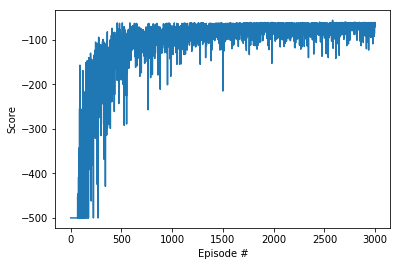

Best 100-episode performance: -67.08 +/- 7.4130695396711355


In [3]:
with open(os.path.join(".", "configs", "Acrobot_v1.json"), "r") as read_file:
    config = json.load(read_file)
    
env = gym.make(config["general"]["env_name"])
env.seed(config["general"]["seed"])
agent = Agent(config=config)

if config["train"]["run_training"]:
    scores, best_mean, best_std = sessions.train(agent, env, config)
    helper.plot_scores(scores)
    print("Best 100-episode performance: {} +/- {}".format(best_mean, best_std))
    agent.save()
else:
    agent.load()
    score = sessions.test(agent, env, config)
    print("Episode score: {}".format(score))

### Environment: CartPole_v1

- CartPole-v0 defines "solving" as getting average reward of 195.0 over 100 consecutive trials.

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode 100	Average Score: 21.19
Episode 200	Average Score: 15.60
Episode 300	Average Score: 12.51
Episode 400	Average Score: 14.74
Episode 500	Average Score: 83.52
Episode 600	Average Score: 193.96
Episode 622	Average Score: 195.04
CartPole-v1 Environment solved in 522 episodes!


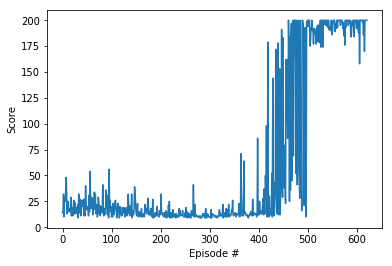

Best 100-episode performance: 195.04 +/- 7.854832907197962


In [4]:
with open(os.path.join(".", "configs", "CartPole_v1.json"), "r") as read_file:
    config = json.load(read_file)
    
env = gym.make(config["general"]["env_name"])
env.seed(config["general"]["seed"])
agent = Agent(config=config)

if config["train"]["run_training"]:
    scores, best_mean, best_std = sessions.train(agent, env, config)
    helper.plot_scores(scores)
    print("Best 100-episode performance: {} +/- {}".format(best_mean, best_std))
    agent.save()
else:
    agent.load()
    score = sessions.test(agent, env, config)
    print("Episode score: {}".format(score))

# Extended Deep Q-Learning for Multilayer Perceptron

This project includes an extended version of the Deep Q-Learning algorithm. 

Deep Q-Learning for Multilayer Perceptron<br>
\+ Fixed Q-Targets<br>
\+ Experience Replay<br>
\+ Gradient Clipping<br>
\+ Double Deep Q-Learning<br>
\+ Dueling Networks<br>

For more information on the implemented features refer to Extended_Deep_Q_Learning_for_Multilayer_Perceptron.ipynb. The notebook includes a summary of all essential concepts used in the code. It also contains three examples where the algorithm is used to solve Open AI gym environments.

### Dependencies

1. Create (and activate) a new environment with Python 3.6.

> conda create --name env_name python=3.6<br>
> source activate env_name

2. Install OpenAi Gym

> git clone https://github.com/openai/gym.git<br>
> cd gym<br>
> pip install -e .<br>
> pip install -e '.[box2d]'<br>
> pip install -e '.[classic_control]'<br>
> sudo apt-get install ffmpeg<br>

3. Install Sourcecode dependencies

> conda install -c rpi matplotlib <br>
> conda install -c pytorch pytorch <br>
> conda install -c anaconda numpy <br>

### Instructions

You can run the project via Extended_Deep_Q_Learning_for_Multilayer_Perceptron.ipynb or running the main.py file through the console.



open the console and run: python main.py -c "your_config_file".json 
optional arguments:

-h, --help

    - show help message
    
-c , --config

    - Config file name - file must be available as .json in ./configs
    
Example: python main.py -c "Lunar_Lander_v2".json 

#### Config File Description

**"general"** : <br>
> "env_name" : "LunarLander-v2", # The gym environment name you want to run<br>
> "monitor_dir" : ["monitor"], # monitor file direction<br>
> "checkpoint_path": ["checkpoints"], # checkpoint file direction<br>
> "seed": 0, # random seed for numpy, gym and pytorch<br>
> "state_size" : 8, # number of states<br>
> "action_size" : 4, # number of actions<br>
> "average_score_for_solving" : 200.0 # border value for solving the task<br>

**"train"** : 
> "nb_episodes": 2000, # max number of episodes<br>
> "episode_length": 1000, # max length of one episode<br>
> "batch_size" : 256, # memory batch size<br>
> "epsilon_high": 1.0, # epsilon start point<br>
> "epsilon_low": 0.01, # min epsilon value<br>
> "epsilon_decay": 0.995, # epsilon decay<br>
> "run_training" : true # do you want to train? Otherwise run a test session<br>

**"agent"** :
> "learning_rate": 0.0005, # model learning rate<br>
> "gamma" : 0.99, # reward weight<br>
> "tau" : 0.001, # soft update factor<br>
> "update_rate" : 4 # interval in which a learning step is done<br>

**"buffer"** :
> "size" : 100000 # experience replay buffer size<br>

**"model"** :
> "fc1_nodes" : 256, # number of fc1 output nodes<br>
> "fc2_adv" : 256, # number of fc2_adv output nodes<br>
> "fc2_val" : 128 # number of fc2_val output nodes<br>